# 04 - How to do FWI with Dask


In [1]:
import sys
sys.path.append('/Users/ggorman/projects/devito')

from devito import configuration
# configuration['log_level'] = 'WARNING'

# import os
# os.environ["DEVITO_DEBUG_COMPILER"] = "0"

from devito import DenseData, clear_cache
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import Model

from examples.seismic import demo_model, plot_velocity, plot_perturbation
from examples.seismic import RickerSource, Receiver

import numpy as np
%matplotlib inline

In [2]:
if configuration['travis_test']:
    # A reduced setup for automated testing
    fwi_iterations = 1  # Number of outer FWI iterations
else:
    # Default setup for demonstration purposes
    fwi_iterations = 10  # Number of outer FWI iterations

In [3]:
# Define true and initial model
def get_grid():
    shape = (101, 101)  # Number of grid point (nx, nz)
    spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
    origin = (0., 0.)  # Need origin to define relative source and receiver locations

    return shape, spacing, origin

def get_true_model():
    shape, spacing, origin = get_grid()
    return demo_model('circle', vp=3.0, vp_background=2.5, 
                      origin=origin, shape=shape, spacing=spacing, nbpml=40)

def get_initial_model():
    shape, spacing, origin = get_grid()

    return demo_model('circle', vp=2.5, vp_background=2.5, 
                      origin=origin, shape=shape, spacing=spacing, nbpml=40)

# Define acquisition geometry: source
def get_data(data, i):
    """ Returns source and receiver data for shot i.
    """
    true_model = get_true_model()
    dt = true_model.critical_dt  # Time step from model grid spacing

    # Set up src
    nt = int(1 + (data['tn']-data['t0']) / dt)  # Discrete time axis length

    src = RickerSource(name='src', ndim=2, f0=data['f0'],
                       time=np.linspace(data['t0'], data['tn'], nt))
    src.coordinates.data[0, :] = [30, i*1000./(data['nshots']-1)]

    # Set up rec
    nreceivers = 101  # Number of receiver locations per shot
    rec = Receiver(name='rec', npoint=nreceivers, ntime=nt, ndim=2)
    rec.coordinates.data[:, 1] = np.linspace(0, true_model.domain_size[0], num=nreceivers)
    rec.coordinates.data[:, 0] = 980. # 20m from the right end

    # Set up solver - using model_in so that we have the same dt
    solver = AcousticWaveSolver(true_model, src, rec, space_order=4)

    # Generate synthetic receiver data from true model
    true_d, _, _ = solver.forward(src=src, m=true_model.m)
    # clear_cache()

    model0 = get_initial_model()
    model0.m.data[:] = data['model']

    return model0, src, true_d, nt, solver

# Create FWI gradient kernel 
def fwi_gradient_i(workpack):
    clear_cache()
    
    data, i = workpack
    model0, src, rec, nt, solver = get_data(data, i)
    
    # Create symbols to hold the gradient and residual
    grad = DenseData(name="grad", shape=model0.shape_domain, dtype=model0.dtype)
    residual = Receiver(name='rec', ntime=nt, coordinates=rec.coordinates.data)
    
    # Compute simulated data and full forward wavefield u0
    d, u0, _ = solver.forward(src=src, m=model0.m, save=True)
        
    # Compute gradient from data residual and update objective function 
    residual.data[:] = d.data[:] - rec.data[:]
    f = .5*np.linalg.norm(residual.data.flatten())**2
    
    solver.gradient(rec=residual, u=u0, m=model0.m, grad=grad)
    
    # Take a copy of the gradient as async-comms can result in the
    # solution being erased (via clear_cache) before reduction is
    # performed.
    g = np.array(grad.data[:])
    
    g[0:25,:] = 0.
    g[-25:,:] = 0.

    return f, g, i

def sum_pairs_g(a, b):
    return (a[0]+b[0], a[1]+b[1], a[2]+b[2])

def sum_g(futures):
    # Simple tree reduction
    while len(futures) > 1:  # while there is more than one element left
        # Add neighbors
        remainder = None
        if len(futures)%2==1:
            remainder = futures[-1]
        futures = [client.submit(sum_pairs_g, a, b)
                   for a, b in zip(futures[::2], futures[1::2])]
        if remainder: 
            futures.append(remainder)
    return futures[0]

def fwi_gradient(parameters):
    remote_data = client.scatter(data=parameters, broadcast=True)
    
    work = [(remote_data, i) for i in range(parameters['nshots'])]
    future = sum_g(client.map(fwi_gradient_i, work))

    f, g, magicnumber = future.result()
        
    return f, g

In [4]:
import dask
from dask import delayed
from dask.distributed import Client

client = Client()

# Set up inversion parameters. We need to make sure that we
# broadcast the model as a numpy array - otherwise dask doesn't
# recognise when it has changed and won't re-broadcast.
param = {'model':get_initial_model().m.data[:],
         't0':0.,
         'tn':1000.,  # Simulation last 1 second (1000 ms)
         'f0':0.010,  # Source peak frequency is 10Hz (0.010 kHz)
         'nshots':21} # Number of shots to create gradient from

/Users/ggorman/anaconda/lib/python3.6/site-packages/distributed/utils.py:118: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 51] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [5]:
f, g = fwi_gradient(param)
print('Objective value is %f ' % f)

np.linalg.norm(param['model'])

Objective value is 137325.854551 


28.960165

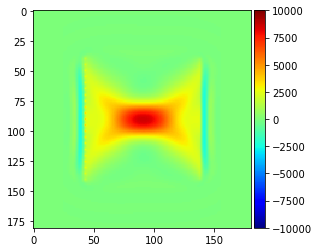

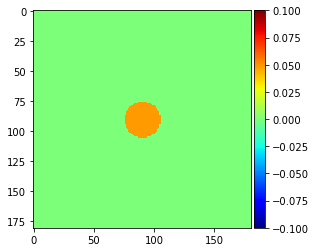

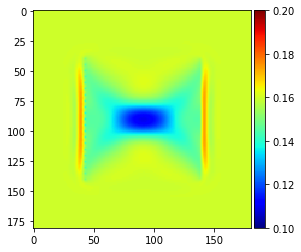

In [6]:
# Plot FWI gradient and model update
from examples.seismic import plot_image

# Plot the FWI gradient
plot_image(g, vmin=-1e4, vmax=1e4, cmap="jet")

# Plot the difference between the true and initial model.
# This is not known in practice as only the initial model is provided.
plot_image(param['model'] - get_true_model().m.data,
           vmin=-1e-1, vmax=1e-1, cmap="jet")

# Show what the update does to the model
alpha = .05 / np.max(g)
plot_image(param['model'] - alpha*g,
           vmin=.1, vmax=.2, cmap="jet")

In [7]:
# Create bounds constraint
def bound_constr(m):
    m[m<.1] = .08 # Maximum accepted velocity is 3.5 km/sec (true is 3 km/sec)
    m[m>.2] = .25 # Minimum accepted velocity is 2 km/sec (true is 2.5 km/sec)
    return m

def fwi(param, fwi_iterations):
    # Run FWI with gradient descent
    history = np.zeros((fwi_iterations, 1))
    for i in range(fwi_iterations):
        param['fwi_iter'] = i
        
        # Compute the functional value and gradient for the current
        # model estimate.
        f, g = fwi_gradient(param)
    
        # Store the history of the functional values.
        history[i] = f
    
        # Artificial Step length for gradient descent
        # In practice this would be replaced by a Linesearch (Wolfe, ...)
        # that would guaranty functional decrease Phi(m-alpha g) <= epsilon Phi(m)
        # where epsilon is a minimum decrease constant
        alpha = .001 / np.max(g)
        
        param['model'] -= alpha * g
        bound_constr(param['model'])
    
        # Log the progress made
        print('Objective value is %f at iteration %d' % (f, i+1))
        print(np.linalg.norm(param['model'].flatten()))
    return history
        
history = fwi(param, fwi_iterations)

Objective value is 137325.854551 at iteration 1
28.9484
Objective value is 128356.081688 at iteration 2
28.9371
Objective value is 119761.521848 at iteration 3
28.9262
Objective value is 111534.062049 at iteration 4
28.9156
Objective value is 103666.705171 at iteration 5
28.9053
Objective value is 96153.017698 at iteration 6
28.8953
Objective value is 88987.272739 at iteration 7
28.8856
Objective value is 82164.076493 at iteration 8
28.8762
Objective value is 75678.053490 at iteration 9
28.8672
Objective value is 69524.076447 at iteration 10
28.8585


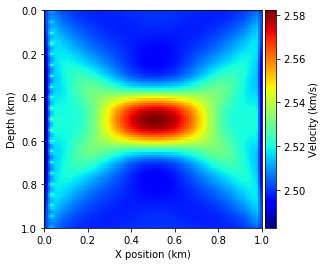

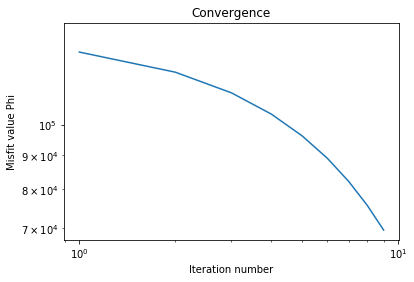

In [8]:
# Plot inverted velocity model

# First, update velocity from computed square slowness
model_n = get_initial_model()
model_n.m.data[:] = param['model']

nbpml = model_n.nbpml
model_n.vp = np.sqrt(1. / model_n.m.data[nbpml:-nbpml, nbpml:-nbpml])

plot_velocity(model_n)

# Plot objective function decrease
import matplotlib.pyplot as plt

plt.figure()
plt.loglog(history)
plt.xlabel('Iteration number')
plt.ylabel('Misfit value Phi')
plt.title('Convergence')
plt.show()